# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [2]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [15]:
model_config_path = "/home/ibrahim/DINO/config/DINO/DINO_4scale_swin.py" # change the path of the model config file
model_checkpoint_path = "/home/ibrahim/DINO/checkpoint0029_4scale_swin.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [16]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


In [17]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# List available zoo datasets
print(foz.list_zoo_datasets())

# Download the COCO-2017 validation split and load it into FiftyOne
dataset = foz.load_zoo_dataset("coco-2017", split="validation")

# Give the dataset a new name, and make it persistent
dataset.name = "coco-2017-validation-example"
dataset.persistent = True

# Visualize it in the App
session = fo.launch_app(dataset)

In [ ]:
args.dataset_file = 'coco'
args.coco_path = "/comp_robot/cv_public_dataset/COCO2017/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

## 1.2 Get an Example and Visualize it

In [6]:
image, targets = dataset_val[0]

In [ ]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [ ]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [9]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

In [ ]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [5]:
from PIL import Image
import datasets.transforms as T

In [18]:
image = Image.open("/home/ibrahim/DINO/dino_img_results/frame_0095.jpg").convert("RGB") # load image

In [19]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [20]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

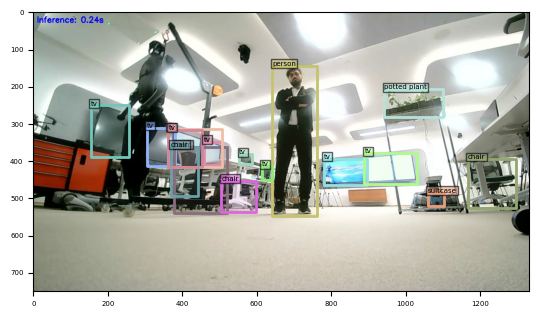

In [21]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

In [12]:
from main import build_model_main
from util.slconfig import SLConfig

args = SLConfig.fromfile("/home/ibrahim/DINO/config/DINO/DINO_4scale_swin.py")
args.device = 'cuda'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load("/home/ibrahim/DINO/checkpoint0029_4scale_swin.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


DINO(
  (transformer): DeformableTransformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
  

In [14]:
import os
import time
import cv2
import torch
import json
import numpy as np
from PIL import Image
from util import box_ops
import datasets.transforms as T

with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k): v for k, v in id2name.items()}

transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

save_dir = "dino_img_results"
os.makedirs(save_dir, exist_ok=True)
frame_counter = 0

RTSP_URL = "rtsp://192.168.1.120:8554/test"

def unnormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(-1, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

def run_live_inference():
    global frame_counter

    cap = cv2.VideoCapture(RTSP_URL)
    if not cap.isOpened():
        print("❌ Failed to open RTSP stream.")
        return

    print("📷 Running DINO-DETR live detection. Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to grab frame.")
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(img_rgb)

        image_tensor, _ = transform(pil_image, None)

        
        with torch.no_grad():
            t0 = time.time()
            output = model.cuda()(image_tensor[None].cuda())
            output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
            t1 = time.time()

        threshold = 0.3
        scores = output['scores']
        labels = output['labels']
        boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
        select_mask = scores > threshold

        selected_boxes = boxes[select_mask]
        selected_labels = labels[select_mask]

        image_vis = unnormalize_image(image_tensor).cpu().permute(1, 2, 0).numpy()
        image_vis = (image_vis * 255).astype('uint8')  # RGB uint8
        image_vis_bgr = cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR)

        for i, box in enumerate(selected_boxes):
            x_c, y_c, w, h = box
            x1 = int((x_c - w / 2).item())
            y1 = int((y_c - h / 2).item())
            x2 = int((x_c + w / 2).item())
            y2 = int((y_c + h / 2).item())

            class_id = int(selected_labels[i].item())
            label = id2name.get(class_id, "unknown")
            cv2.rectangle(image_vis_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image_vis_bgr, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        cv2.putText(image_vis_bgr, f"Inference: {t1 - t0:.2f}s", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        cv2.imshow("DINO-DETR Live", image_vis_bgr)
        frame_counter += 1
        save_path = os.path.join(save_dir, f"frame_{frame_counter:04d}.jpg")
        cv2.imwrite(save_path, image_vis_bgr)
        print(f"💾 Saved: {save_path}")

        # Quit on 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("👋 Exiting DINO-DETR live detection.")
            break

    cap.release()
    cv2.destroyAllWindows()

run_live_inference()


📷 Running DINO-DETR live detection. Press 'q' to quit.
💾 Saved: dino_img_results/frame_0001.jpg
💾 Saved: dino_img_results/frame_0002.jpg
💾 Saved: dino_img_results/frame_0003.jpg
💾 Saved: dino_img_results/frame_0004.jpg
💾 Saved: dino_img_results/frame_0005.jpg
💾 Saved: dino_img_results/frame_0006.jpg
💾 Saved: dino_img_results/frame_0007.jpg
💾 Saved: dino_img_results/frame_0008.jpg
💾 Saved: dino_img_results/frame_0009.jpg
💾 Saved: dino_img_results/frame_0010.jpg
💾 Saved: dino_img_results/frame_0011.jpg
💾 Saved: dino_img_results/frame_0012.jpg
💾 Saved: dino_img_results/frame_0013.jpg
💾 Saved: dino_img_results/frame_0014.jpg
💾 Saved: dino_img_results/frame_0015.jpg
💾 Saved: dino_img_results/frame_0016.jpg
💾 Saved: dino_img_results/frame_0017.jpg
💾 Saved: dino_img_results/frame_0018.jpg
💾 Saved: dino_img_results/frame_0019.jpg
💾 Saved: dino_img_results/frame_0020.jpg
💾 Saved: dino_img_results/frame_0021.jpg
💾 Saved: dino_img_results/frame_0022.jpg
💾 Saved: dino_img_results/frame_0023.jpg
💾 

[h264 @ 0xc77e9700] error while decoding MB 32 27, bytestream -7


💾 Saved: dino_img_results/frame_0030.jpg
💾 Saved: dino_img_results/frame_0031.jpg
💾 Saved: dino_img_results/frame_0032.jpg
💾 Saved: dino_img_results/frame_0033.jpg
💾 Saved: dino_img_results/frame_0034.jpg
💾 Saved: dino_img_results/frame_0035.jpg


[h264 @ 0xa9b84740] error while decoding MB 34 38, bytestream -5


💾 Saved: dino_img_results/frame_0036.jpg
💾 Saved: dino_img_results/frame_0037.jpg
💾 Saved: dino_img_results/frame_0038.jpg
💾 Saved: dino_img_results/frame_0039.jpg
💾 Saved: dino_img_results/frame_0040.jpg
💾 Saved: dino_img_results/frame_0041.jpg


[h264 @ 0x88fb9600] error while decoding MB 19 37, bytestream -9


💾 Saved: dino_img_results/frame_0042.jpg
💾 Saved: dino_img_results/frame_0043.jpg
💾 Saved: dino_img_results/frame_0044.jpg
💾 Saved: dino_img_results/frame_0045.jpg
💾 Saved: dino_img_results/frame_0046.jpg
💾 Saved: dino_img_results/frame_0047.jpg


[h264 @ 0x2e945b00] cabac decode of qscale diff failed at 51 8
[h264 @ 0x2e945b00] error while decoding MB 51 8, bytestream -7


💾 Saved: dino_img_results/frame_0048.jpg
💾 Saved: dino_img_results/frame_0049.jpg
💾 Saved: dino_img_results/frame_0050.jpg
💾 Saved: dino_img_results/frame_0051.jpg
💾 Saved: dino_img_results/frame_0052.jpg
💾 Saved: dino_img_results/frame_0053.jpg
💾 Saved: dino_img_results/frame_0054.jpg
💾 Saved: dino_img_results/frame_0055.jpg
💾 Saved: dino_img_results/frame_0056.jpg
💾 Saved: dino_img_results/frame_0057.jpg


[h264 @ 0xa9b84740] error while decoding MB 12 34, bytestream -31


💾 Saved: dino_img_results/frame_0058.jpg
💾 Saved: dino_img_results/frame_0059.jpg
💾 Saved: dino_img_results/frame_0060.jpg
💾 Saved: dino_img_results/frame_0061.jpg
💾 Saved: dino_img_results/frame_0062.jpg
💾 Saved: dino_img_results/frame_0063.jpg
💾 Saved: dino_img_results/frame_0064.jpg
💾 Saved: dino_img_results/frame_0065.jpg
💾 Saved: dino_img_results/frame_0066.jpg
💾 Saved: dino_img_results/frame_0067.jpg
💾 Saved: dino_img_results/frame_0068.jpg
💾 Saved: dino_img_results/frame_0069.jpg
💾 Saved: dino_img_results/frame_0070.jpg


[h264 @ 0x1d8d3cb80] error while decoding MB 42 12, bytestream -5


💾 Saved: dino_img_results/frame_0071.jpg
💾 Saved: dino_img_results/frame_0072.jpg
💾 Saved: dino_img_results/frame_0073.jpg
💾 Saved: dino_img_results/frame_0074.jpg
💾 Saved: dino_img_results/frame_0075.jpg
💾 Saved: dino_img_results/frame_0076.jpg
💾 Saved: dino_img_results/frame_0077.jpg


[h264 @ 0x95662300] cabac decode of qscale diff failed at 58 6
[h264 @ 0x95662300] error while decoding MB 58 6, bytestream -5


💾 Saved: dino_img_results/frame_0078.jpg
💾 Saved: dino_img_results/frame_0079.jpg
💾 Saved: dino_img_results/frame_0080.jpg
💾 Saved: dino_img_results/frame_0081.jpg
💾 Saved: dino_img_results/frame_0082.jpg
💾 Saved: dino_img_results/frame_0083.jpg
💾 Saved: dino_img_results/frame_0084.jpg
💾 Saved: dino_img_results/frame_0085.jpg
💾 Saved: dino_img_results/frame_0086.jpg
💾 Saved: dino_img_results/frame_0087.jpg
💾 Saved: dino_img_results/frame_0088.jpg
💾 Saved: dino_img_results/frame_0089.jpg
💾 Saved: dino_img_results/frame_0090.jpg
💾 Saved: dino_img_results/frame_0091.jpg
💾 Saved: dino_img_results/frame_0092.jpg
💾 Saved: dino_img_results/frame_0093.jpg
💾 Saved: dino_img_results/frame_0094.jpg
💾 Saved: dino_img_results/frame_0095.jpg


[h264 @ 0x2eec6ec0] error while decoding MB 31 31, bytestream -9


💾 Saved: dino_img_results/frame_0096.jpg


[h264 @ 0x2e05e340] error while decoding MB 17 12, bytestream -11


💾 Saved: dino_img_results/frame_0097.jpg
💾 Saved: dino_img_results/frame_0098.jpg
💾 Saved: dino_img_results/frame_0099.jpg
💾 Saved: dino_img_results/frame_0100.jpg
💾 Saved: dino_img_results/frame_0101.jpg
💾 Saved: dino_img_results/frame_0102.jpg
💾 Saved: dino_img_results/frame_0103.jpg
💾 Saved: dino_img_results/frame_0104.jpg
💾 Saved: dino_img_results/frame_0105.jpg
💾 Saved: dino_img_results/frame_0106.jpg
💾 Saved: dino_img_results/frame_0107.jpg
💾 Saved: dino_img_results/frame_0108.jpg


[h264 @ 0x1d1242480] error while decoding MB 48 8, bytestream -9


💾 Saved: dino_img_results/frame_0109.jpg
💾 Saved: dino_img_results/frame_0110.jpg
💾 Saved: dino_img_results/frame_0111.jpg


[h264 @ 0xae3d7e40] error while decoding MB 17 44, bytestream -7


💾 Saved: dino_img_results/frame_0112.jpg
💾 Saved: dino_img_results/frame_0113.jpg
💾 Saved: dino_img_results/frame_0114.jpg
💾 Saved: dino_img_results/frame_0115.jpg
💾 Saved: dino_img_results/frame_0116.jpg
💾 Saved: dino_img_results/frame_0117.jpg
💾 Saved: dino_img_results/frame_0118.jpg
💾 Saved: dino_img_results/frame_0119.jpg
💾 Saved: dino_img_results/frame_0120.jpg
💾 Saved: dino_img_results/frame_0121.jpg
💾 Saved: dino_img_results/frame_0122.jpg
💾 Saved: dino_img_results/frame_0123.jpg
💾 Saved: dino_img_results/frame_0124.jpg
💾 Saved: dino_img_results/frame_0125.jpg
💾 Saved: dino_img_results/frame_0126.jpg
💾 Saved: dino_img_results/frame_0127.jpg
💾 Saved: dino_img_results/frame_0128.jpg


[h264 @ 0x95662300] error while decoding MB 18 21, bytestream -9


💾 Saved: dino_img_results/frame_0129.jpg


[h264 @ 0xc71f2640] error while decoding MB 54 44, bytestream -7


💾 Saved: dino_img_results/frame_0130.jpg
💾 Saved: dino_img_results/frame_0131.jpg
💾 Saved: dino_img_results/frame_0132.jpg
💾 Saved: dino_img_results/frame_0133.jpg
💾 Saved: dino_img_results/frame_0134.jpg


[h264 @ 0xc77e9700] error while decoding MB 66 16, bytestream -13


💾 Saved: dino_img_results/frame_0135.jpg
💾 Saved: dino_img_results/frame_0136.jpg
💾 Saved: dino_img_results/frame_0137.jpg
💾 Saved: dino_img_results/frame_0138.jpg


[h264 @ 0x2eec6ec0] error while decoding MB 58 23, bytestream -31


💾 Saved: dino_img_results/frame_0139.jpg
💾 Saved: dino_img_results/frame_0140.jpg
💾 Saved: dino_img_results/frame_0141.jpg
💾 Saved: dino_img_results/frame_0142.jpg
💾 Saved: dino_img_results/frame_0143.jpg
💾 Saved: dino_img_results/frame_0144.jpg
💾 Saved: dino_img_results/frame_0145.jpg
💾 Saved: dino_img_results/frame_0146.jpg
💾 Saved: dino_img_results/frame_0147.jpg
💾 Saved: dino_img_results/frame_0148.jpg
💾 Saved: dino_img_results/frame_0149.jpg
💾 Saved: dino_img_results/frame_0150.jpg
💾 Saved: dino_img_results/frame_0151.jpg
💾 Saved: dino_img_results/frame_0152.jpg
💾 Saved: dino_img_results/frame_0153.jpg
💾 Saved: dino_img_results/frame_0154.jpg
💾 Saved: dino_img_results/frame_0155.jpg
💾 Saved: dino_img_results/frame_0156.jpg
💾 Saved: dino_img_results/frame_0157.jpg
💾 Saved: dino_img_results/frame_0158.jpg
💾 Saved: dino_img_results/frame_0159.jpg
💾 Saved: dino_img_results/frame_0160.jpg
💾 Saved: dino_img_results/frame_0161.jpg
💾 Saved: dino_img_results/frame_0162.jpg
💾 Saved: dino_im

[h264 @ 0x1d99ad780] error while decoding MB 66 30, bytestream -5


💾 Saved: dino_img_results/frame_0165.jpg


[h264 @ 0x1d99b3ac0] error while decoding MB 14 19, bytestream -5


💾 Saved: dino_img_results/frame_0166.jpg
💾 Saved: dino_img_results/frame_0167.jpg
💾 Saved: dino_img_results/frame_0168.jpg
💾 Saved: dino_img_results/frame_0169.jpg
💾 Saved: dino_img_results/frame_0170.jpg
💾 Saved: dino_img_results/frame_0171.jpg


[h264 @ 0x2e05e340] error while decoding MB 52 38, bytestream -5


💾 Saved: dino_img_results/frame_0172.jpg
💾 Saved: dino_img_results/frame_0173.jpg
💾 Saved: dino_img_results/frame_0174.jpg
💾 Saved: dino_img_results/frame_0175.jpg
💾 Saved: dino_img_results/frame_0176.jpg
💾 Saved: dino_img_results/frame_0177.jpg


[h264 @ 0xc71f2640] error while decoding MB 34 37, bytestream -7


💾 Saved: dino_img_results/frame_0178.jpg
💾 Saved: dino_img_results/frame_0179.jpg
💾 Saved: dino_img_results/frame_0180.jpg
💾 Saved: dino_img_results/frame_0181.jpg


[h264 @ 0x1d1242480] error while decoding MB 63 30, bytestream -7


💾 Saved: dino_img_results/frame_0182.jpg
💾 Saved: dino_img_results/frame_0183.jpg
💾 Saved: dino_img_results/frame_0184.jpg
💾 Saved: dino_img_results/frame_0185.jpg
💾 Saved: dino_img_results/frame_0186.jpg


[h264 @ 0x2e05e340] error while decoding MB 64 11, bytestream -5


💾 Saved: dino_img_results/frame_0187.jpg
💾 Saved: dino_img_results/frame_0188.jpg
💾 Saved: dino_img_results/frame_0189.jpg
💾 Saved: dino_img_results/frame_0190.jpg
💾 Saved: dino_img_results/frame_0191.jpg
💾 Saved: dino_img_results/frame_0192.jpg
💾 Saved: dino_img_results/frame_0193.jpg
💾 Saved: dino_img_results/frame_0194.jpg
💾 Saved: dino_img_results/frame_0195.jpg
💾 Saved: dino_img_results/frame_0196.jpg
💾 Saved: dino_img_results/frame_0197.jpg
💾 Saved: dino_img_results/frame_0198.jpg
💾 Saved: dino_img_results/frame_0199.jpg
💾 Saved: dino_img_results/frame_0200.jpg
💾 Saved: dino_img_results/frame_0201.jpg
💾 Saved: dino_img_results/frame_0202.jpg


[h264 @ 0x99eb7f80] error while decoding MB 31 12, bytestream -5


💾 Saved: dino_img_results/frame_0203.jpg
💾 Saved: dino_img_results/frame_0204.jpg
💾 Saved: dino_img_results/frame_0205.jpg
💾 Saved: dino_img_results/frame_0206.jpg
💾 Saved: dino_img_results/frame_0207.jpg
💾 Saved: dino_img_results/frame_0208.jpg
💾 Saved: dino_img_results/frame_0209.jpg
💾 Saved: dino_img_results/frame_0210.jpg
💾 Saved: dino_img_results/frame_0211.jpg
💾 Saved: dino_img_results/frame_0212.jpg
💾 Saved: dino_img_results/frame_0213.jpg
💾 Saved: dino_img_results/frame_0214.jpg
💾 Saved: dino_img_results/frame_0215.jpg
💾 Saved: dino_img_results/frame_0216.jpg
💾 Saved: dino_img_results/frame_0217.jpg


[h264 @ 0x2f036980] error while decoding MB 44 5, bytestream -9


💾 Saved: dino_img_results/frame_0218.jpg
💾 Saved: dino_img_results/frame_0219.jpg


[h264 @ 0x1d8d3cb80] error while decoding MB 69 30, bytestream -9


💾 Saved: dino_img_results/frame_0220.jpg
💾 Saved: dino_img_results/frame_0221.jpg
💾 Saved: dino_img_results/frame_0222.jpg
💾 Saved: dino_img_results/frame_0223.jpg
💾 Saved: dino_img_results/frame_0224.jpg
💾 Saved: dino_img_results/frame_0225.jpg


[h264 @ 0xbf2ec900] error while decoding MB 54 38, bytestream -7


💾 Saved: dino_img_results/frame_0226.jpg
💾 Saved: dino_img_results/frame_0227.jpg
💾 Saved: dino_img_results/frame_0228.jpg
💾 Saved: dino_img_results/frame_0229.jpg


[h264 @ 0x1d99b3ac0] error while decoding MB 23 42, bytestream -7


💾 Saved: dino_img_results/frame_0230.jpg


[h264 @ 0x1d8d3cb80] error while decoding MB 49 42, bytestream -5
[h264 @ 0x2eec6ec0] error while decoding MB 13 31, bytestream -9


💾 Saved: dino_img_results/frame_0231.jpg
💾 Saved: dino_img_results/frame_0232.jpg
💾 Saved: dino_img_results/frame_0233.jpg
💾 Saved: dino_img_results/frame_0234.jpg
💾 Saved: dino_img_results/frame_0235.jpg
💾 Saved: dino_img_results/frame_0236.jpg
💾 Saved: dino_img_results/frame_0237.jpg
💾 Saved: dino_img_results/frame_0238.jpg
💾 Saved: dino_img_results/frame_0239.jpg
💾 Saved: dino_img_results/frame_0240.jpg
💾 Saved: dino_img_results/frame_0241.jpg
💾 Saved: dino_img_results/frame_0242.jpg
💾 Saved: dino_img_results/frame_0243.jpg
💾 Saved: dino_img_results/frame_0244.jpg
💾 Saved: dino_img_results/frame_0245.jpg
💾 Saved: dino_img_results/frame_0246.jpg
💾 Saved: dino_img_results/frame_0247.jpg
💾 Saved: dino_img_results/frame_0248.jpg


[h264 @ 0xbf2ec900] error while decoding MB 74 23, bytestream -5


💾 Saved: dino_img_results/frame_0249.jpg
💾 Saved: dino_img_results/frame_0250.jpg
💾 Saved: dino_img_results/frame_0251.jpg
💾 Saved: dino_img_results/frame_0252.jpg
💾 Saved: dino_img_results/frame_0253.jpg
💾 Saved: dino_img_results/frame_0254.jpg


[h264 @ 0x1d99b3ac0] error while decoding MB 11 39, bytestream -7


💾 Saved: dino_img_results/frame_0255.jpg
💾 Saved: dino_img_results/frame_0256.jpg
💾 Saved: dino_img_results/frame_0257.jpg
💾 Saved: dino_img_results/frame_0258.jpg
💾 Saved: dino_img_results/frame_0259.jpg
💾 Saved: dino_img_results/frame_0260.jpg
👋 Exiting DINO-DETR live detection.
